Lauri Pelin <br>
February, 8, 2023  <br>

# Exercise 2 | TKO_7092 Evaluation of Machine Learning Methods 2023

### Prediction of the metal ion content from multi-parameter data
##### Use K-Nearest Neighbor Regression with euclidean distance to predict total metal concentration (c_total), concentration of Cadmium (Cd) and concentration of Lead (Pb), for each sample using number of neighbors k = 3.<br> 

    - You may use Nearest Neighbor Regression from https://scikit-learn.org/stable/modules/neighbors.html
    - The data should be standarized using z-score. (Using sklearn.preprocessing.StandardScaler is allowed)
    - Implement your own Leave-One-Out cross-validation and calculate the C-index for each output (c_total, Cd, Pb). 
    - Implement your own Leave-Replicas-Out cross-validation and calculate the C-index for each output (c_total, Cd, Pb).
    - Return your solution as a Jupyter Notebook .ipynb notebook and as a PDF-file made from it.
    - Submit to moodle your solution on ** Wednesday 8 of February ** at the latest.

## Import libraries

In [1]:
#In this cell import all libraries you need. For example: 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

## Read and visualize the dataset

In [28]:
#In this cell read the file Water_data.csv
#Print the dataset dimesions (i.e. number of rows and columns)
#Print the first 5 rows of the dataset

# Path for the data
data_path = 'Water_data.csv'

# Create a dataframe
water_data = pd.read_csv(data_path)
#Check the dataframe
print("dataset dimensions are",water_data.shape) #dataset dimensions
water_data.head(5) #first 5 rows of the dataset

dataset dimensions are (225, 6)


,c_total,Cd,Pb,Mod1,Mod2,Mod3
0,0,0.0,0.0,9945,119,72335
1,0,0.0,0.0,10786,117,82977
2,0,0.0,0.0,10812,120,98594
3,14,0.0,14.0,9742,127,154323
4,14,0.0,14.0,8495,120,131672


#### To show understanding of the data, answer the following questions:
- How many different mixtures of Cadmium (Cd) and Lead (Pb) were measured? <br>
- 67
- How many total concentrations (c_total) were measured? <br>
- 225
- How many mixtures have less than 4 replicas? <br>
- 0
- Make plots of Lead (Pb) and Cadmium (Cd) mixtures for low and high concentrations. <br>
Where low concentrations are those with c_total <= 100, while in high concentration c_total > 100.<br>
Hint: plots are similar to the ones presented in the video lecture.  

(67, 2)
(225, 1)
0


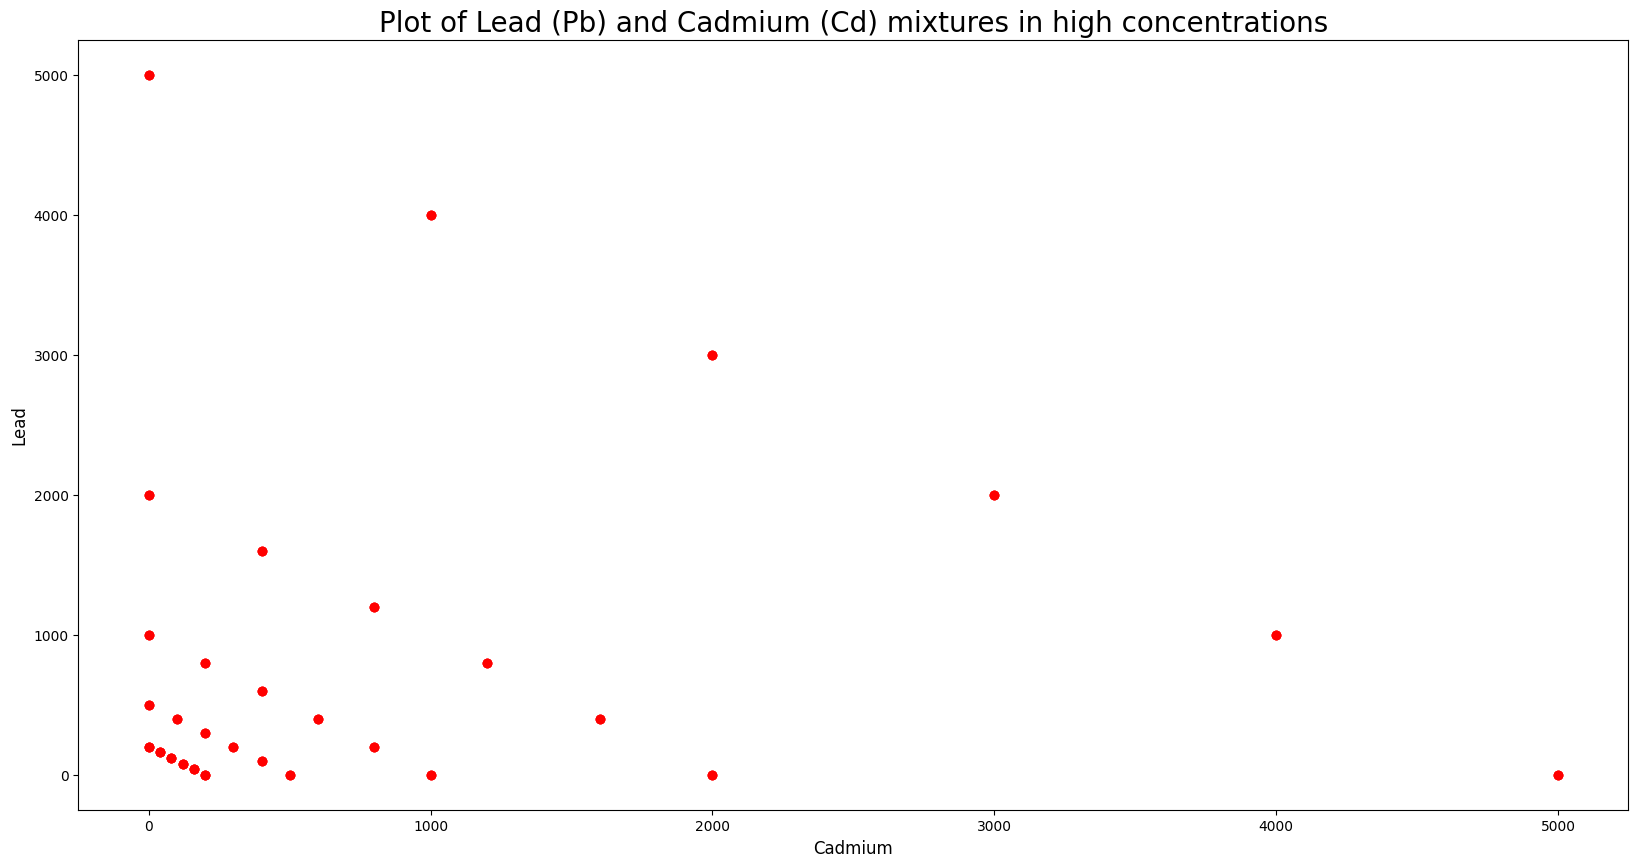

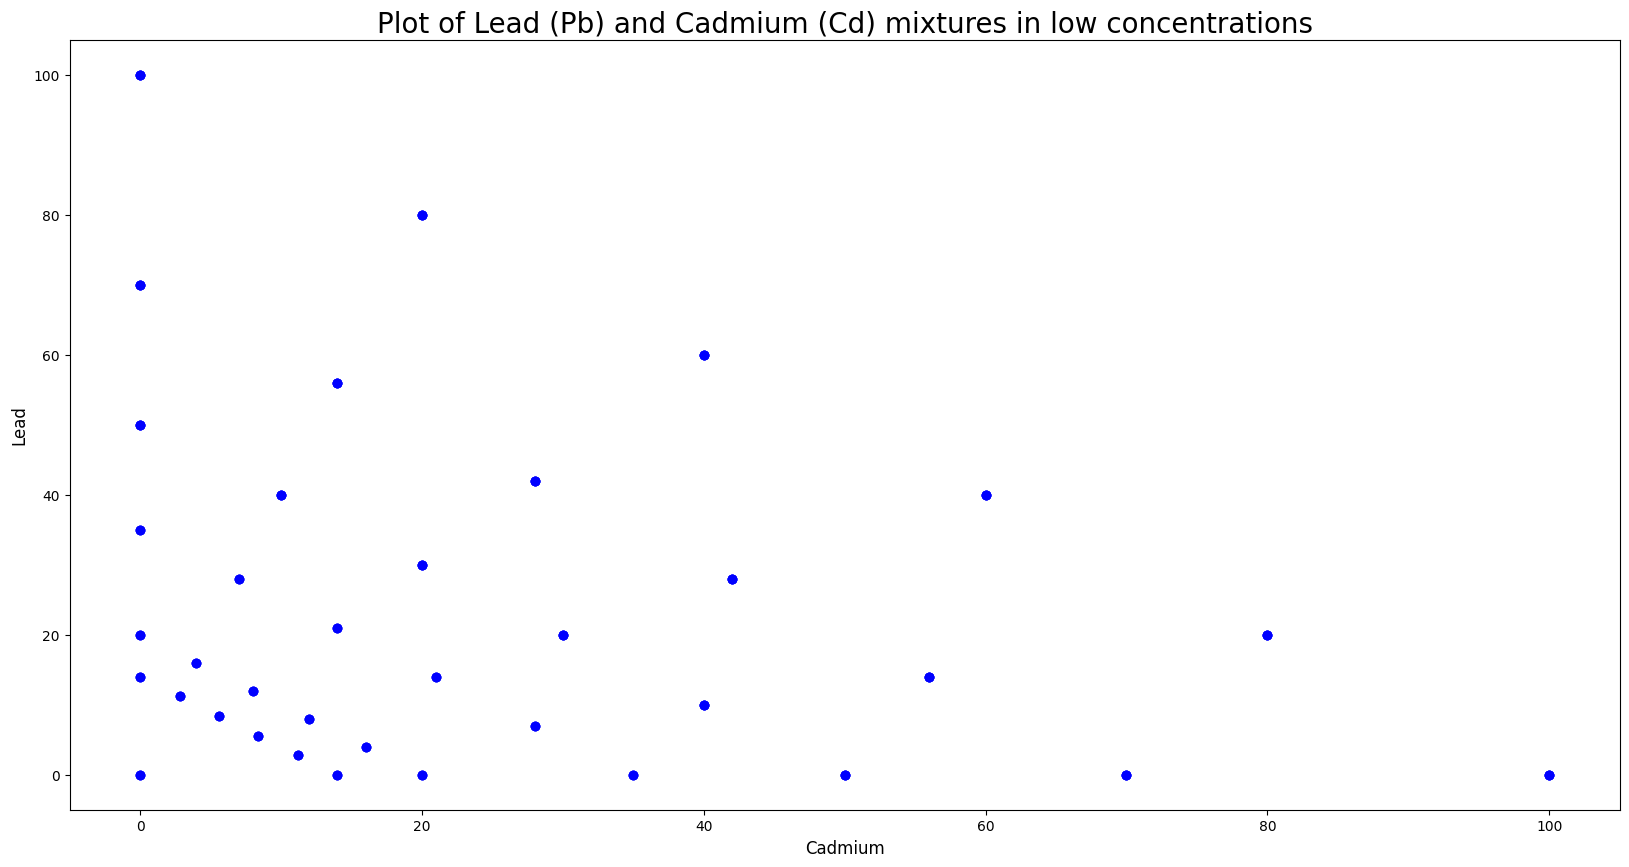

In [31]:
#In this cell write the code to answer the previous questions and print the answers.

#print(water_data[['Cd', 'Pb']].shape)
print(water_data[['Cd', 'Pb']].drop_duplicates().shape) #no duplicates

print(water_data[['c_total']].dropna().shape) #total concentrations as in with duplicates
#print(water_data[['c_total']].drop_duplicates().shape)

c = 0
for index, row in water_data.iterrows():
    Cd = row['Cd']
    Pb = row['Pb']
    d = 0
    d_boolean = False
    for index, row in water_data.iterrows():
        Cd1 = row['Cd']
        Pb1 = row['Pb']
        if Cd == Cd1 and Pb == Pb1:
            d_boolean = True
            d =+ 1
            if d < 4:
                d_boolean = False
                break
    if d_boolean:
        c =+ 1
print(c)

high_concent = water_data[water_data.c_total > 100]
low_concent = water_data[water_data.c_total <= 100]

plt.figure(figsize=(20,10))
plt.title("Plot of Lead (Pb) and Cadmium (Cd) mixtures in high concentrations", fontsize=20)
plt.xlabel("Cadmium", fontsize=12)
plt.ylabel("Lead", fontsize=12)
plt.scatter(high_concent['Cd'],high_concent['Pb'], color='red') #red for high
plt.show()

plt.figure(figsize=(20,10))
plt.title("Plot of Lead (Pb) and Cadmium (Cd) mixtures in low concentrations", fontsize=20)
plt.xlabel("Cadmium", fontsize=12)
plt.ylabel("Lead", fontsize=12)
plt.scatter(low_concent['Cd'],low_concent['Pb'], color='blue') #blue for low
plt.show()

## Standardization of the dataset

In [32]:
#In this cell standardize the dataset features by removing the mean and scaling to unit variance. 
#In other words, use z-score to scale the dataset features (Mod1, Mod2, Mod3) 
#Print the 5 first samples (i.e. rows) of the scaled dataset

mods = water_data[['Mod1', 'Mod2', 'Mod3']]
sc = StandardScaler()
mod = pd.DataFrame(sc.fit_transform(mods))
mod.columns = ['Mod1','Mod2','Mod3']
print(mod.head(5))

C_total = water_data['c_total']
Cd_S = water_data['Cd']
Pb_S = water_data['Pb']
water_data2 = pd.concat([C_total, Cd_S, Pb_S, mod], axis = 1)
print(water_data2.head(5))


       Mod1      Mod2      Mod3
0 -0.999216 -0.714208 -0.414911
1 -0.990800 -0.714373 -0.238335
2 -0.990539 -0.714125  0.020788
3 -1.001247 -0.713546  0.945465
4 -1.013727 -0.714125  0.569631
   c_total   Cd    Pb      Mod1      Mod2      Mod3
0        0  0.0   0.0 -0.999216 -0.714208 -0.414911
1        0  0.0   0.0 -0.990800 -0.714373 -0.238335
2        0  0.0   0.0 -0.990539 -0.714125  0.020788
3       14  0.0  14.0 -1.001247 -0.713546  0.945465
4       14  0.0  14.0 -1.013727 -0.714125  0.569631


## C-index code 

In [5]:
def cindex(true_labels, pred_labels):
    """Returns C-index between true labels and predicted labels"""
    #Had some difficulties implementing this so I asked ChatGPT for help which in turn showed me a sample
    #from Harrell’s C-index which I modified for this implementation.
    n = len(true_labels)
    concordant = 0
    discordant = 0
    for i in range(n):
        for j in range(i + 1, n):
            if true_labels[i] > true_labels[j]:
                if pred_labels[i] > pred_labels[j]:
                    concordant += 1
                elif pred_labels[i] < pred_labels[j]:
                    discordant += 1
            elif true_labels[i] < true_labels[j]:
                if pred_labels[i] < pred_labels[j]:
                    concordant += 1
                elif pred_labels[i] > pred_labels[j]:
                    discordant += 1
    cindx = 0
    if (concordant + discordant) != 0:
        cindx = concordant / (concordant + discordant)
    return cindx

In [6]:
#test cindex function with following values
true_labels = [-1, 1, 1, -1, 1]
predictions = [0.60, 0.80, 0.75, 0.75, 0.70]
cindx = cindex(true_labels, predictions)
print(cindx)

0.8


## Functions

Include here all the functions that you need to run in the data analysis part.<br>
**Note:** using a leave-one-out and leave-replicas-out cross-validation from an already made package (e.g. Scikit-learn) is not accepted.

In [33]:
def loo_cindex(X, y): #leave-one-out
    preds = []
    X2 = X.copy()
    y2 = y.copy()
    fits=len(X2)
    for i in range(0, len(X2)):
        X_train = X2.drop([i])
        y_train = y2.drop([i])
        X_test = (np.asarray(X2.loc[i][:])).reshape(1, -1)
        knn = KNeighborsRegressor(n_neighbors=3) #3 as instructed
        knn.fit(X_train.values, y_train)
        pred = knn.predict(X_test)
        preds.append(pred)
        #print(pred)
    #print(y2)
    #print(preds)
    #print(fits)
    return cindex(y2, preds)

In [19]:
#leave-replicas-out: loop, count replicas, return values to cindex
def lro_cindex(data, dr1, dr2, X, y):
    folds = []
    trains = []
    preds = []
    i = 0
    while i < len(data): #loop
        cr1 = dr1[i] # current row
        cr2 = dr2[i]
        replicas = 0
        for j in range(i, len(data)): # count for replicas
            if dr1[j] == cr1 and dr2[j] == cr2:
                replicas += 1
            else:
                break
        folds.append(data.loc[i: i + replicas - 1])
        removed = list(range(i, i + replicas)) #removed rows
        trains.append(data.drop(removed))
        i += replicas # skip the replicated rows

    for i in range(0, len(data)): # edge rows
        try:
            train_all = trains[i]
            fold_all = folds[i]
        except:
            #print("No edge cases found")
            pass
        
        x_train = train_all[list(X)] 
        y_train = train_all[(y)] 
        x_test = fold_all[list(X)]

        knn = KNeighborsRegressor(n_neighbors = 3) # 3 as instructed
        knn.fit(x_train, y_train)
        pred = knn.predict(x_test)
        preds.extend(pred)
        #print(replicas)
    return(cindex(data[(y)],preds))

## Results for Leave-One-Out cross-validation

In [34]:
#In this cell run your script for Leave-One-Out cross-validation and print the corresponding results.
print('C-index for total concentration using leave-one-out cross-validation:', loo_cindex(water_data2[['Mod1', 'Mod2', 'Mod3']],  water_data2['c_total']))
print('C-index for Pb concentration using leave-one-out cross-validation:   ', loo_cindex(water_data2[['Mod1', 'Mod2', 'Mod3']],  water_data2['Pb']))
print('C-index for Cd concentration using leave-one-out cross-validation:   ', loo_cindex(water_data2[['Mod1', 'Mod2', 'Mod3']],  water_data2['Cd']))

C-index for total concentration using leave-one-out cross-validation: 0.9176924087783083
C-index for Pb concentration using leave-one-out cross-validation:    0.8765432098765432
C-index for Cd concentration using leave-one-out cross-validation:    0.9023631317803381


## Results for Leave-Replicas-Out cross-validation

In [35]:
#In this cell run your script for Leave-Replicas-Out cross-validation and print the corresponding results.
water_data3 = water_data2
Pb3 = water_data3['Pb']
Cd3 = water_data3['Cd']
mods = ['Mod1','Mod2','Mod3']

print('C-index for total concentration using leave-replicas-out cross-validation: ', lro_cindex(water_data3, Cd3, Pb3, mods, 'c_total'))
print('C-index for Pb concentration using leave-replicas-out cross-validation:    ', lro_cindex(water_data3, Cd3, Pb3, mods, 'Pb'))
print('C-index for Cd concentration using leave-replicas-out cross-validation:    ', lro_cindex(water_data3, Cd3, Pb3, mods, 'Cd'))

C-index for total concentration using leave-replicas-out cross-validation:  0.8248682637382102
C-index for Pb concentration using leave-replicas-out cross-validation:     0.7710990444921497
C-index for Cd concentration using leave-replicas-out cross-validation:     0.763354925548919


## Interpretation of results
#### Answer the following questions based on the results obtained
- Which cross-validation approach had more optimistic results?
- Which cross-validation generalize better on unseen data? Why?

### In this cell write your answers to the questions about Interpretation of Results.
##### Leave-One-Out cross-validation had considerably better cindex results:
    C-index for total concentration: 0.917 vs 0.824
    C-index for Pb concentration:    0.876 vs 0.771
    C-index for Cd concentration:    0.902 vs 0.763

##### As to the latter question, leave-replicas-out cross-validation to my understanding is supposed to be less computationally demanding due to the fewer fits depending on the amount of replicas but this comes at the cost of reduced accuracy compared to the leave-one-out cross-validation. However, one should not forget that Leave-one-out has it's own weakness in possible overfitting on unseen data as well. 

##### As such I'm advocating for leave-replicas-out cross-validation to generalize better on unseen data due to the lessened risk of overfitting.


